# Week 3 CNN Cancer Detection Kaggle Mini-Project
This is my project for the Deep Learning course focused on convolutional neural networks. You can find more info on GiHub on my profile [here](https://github.com/rorrostieta/KaggleCancerDetection). I'll be following the rubric given to create this project and guide you through my proces for the competition.

The data can be found on Kaggle on the competition [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection/) you can go there and look for more details to participate on the competition.

## Problem
In this competition we're given a series of small images or snippets from pathology scans, each of this scans may contain some cancerous tissue within them. Our goal is to create a model which identifies the presence of cancerous tissue within the images, since we're not doctors or specialists with the domain knowledge, the data provided to train the model is labelled where if there is an area of the image which contains cancerous tissue it is identified with a number 1.

## Exploratory Data Analysis
I'll be doing some basic EDA just to see if the data provided could be cleaned out and see how it is labeled.

In [1]:
import pandas as pd
import numpy as np
from PIL import Image

# Importing the Data
df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv', dtype=str)

In [2]:
# General info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB


% Positive Cases: 0    59.5
1    40.5
Name: label, dtype: float64
% Nevative Cases: 0    40.5
1    59.5
Name: label, dtype: float64


<AxesSubplot:>

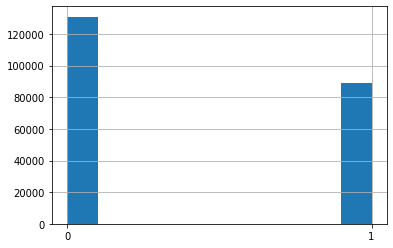

In [3]:
# Histogram to label distribution
pos_percent = round(df['label'].value_counts()/len(df['label'])*100, 2)
neg_percent = 100 - pos_percent
print('% Positive Cases:',pos_percent)
print('% Nevative Cases:',neg_percent)
df['label'].hist()

Sample Img


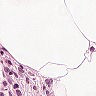

Image size: (96, 96)
Image as array shape: (96, 96, 3)


In [4]:
df.id = df.id + '.tif'

# Extracting a file to identify the structure
eda_file = df['id'][0]
im = Image.open(f'../input/histopathologic-cancer-detection/train/{eda_file}')

print('Sample Img')
display(im)
print('Image size:',im.size)

# Converting in to an array
imarray = np.array(im)
print('Image as array shape:',imarray.shape)
# print(imarray)

### EDA Results
The results from the EDA we show that we have 220,025 entries with a 60/40 negative positive ratio respectively, this is useful since we have a good amount of examples to train the model.

Each of the entry has an **id** corresponding to an image within the data set provided. This images are of size 96x96 pixels and when we transform these into arrays we can obtain the three planes RGB.

## Model Architecture
For this part I'm going to be starting off with the [VGG16](https://keras.io/api/applications/vgg/) architecture via transfer learning. After having part of the model within I'll add an additional set of layers to reduce the output even more for something interpretable by the model.

In [5]:
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *

First we have to set up the model with the trainig data creating both loaders for the train and validation data within the splits. I use a lot of the default values regarding the batch size and some hyperparameters due to computational intensiveness.

In [6]:
train, test = train_test_split(df, stratify=df.label)
generator = ImageDataGenerator(rescale=1/255)

In [7]:
train_load = generator.flow_from_dataframe(
    dataframe = train,
    directory = '../input/histopathologic-cancer-detection/train',
    x_col = 'id',
    y_col = 'label',
    class_mode = 'categorical',
    target_size = (96, 96)
)

test_load = generator.flow_from_dataframe(
    dataframe = test,
    directory = '../input/histopathologic-cancer-detection/train',
    x_col = 'id',
    y_col = 'label',
    class_mode = 'categorical',
    target_size = (96, 96)
)

Found 165018 validated image filenames belonging to 2 classes.
Found 55007 validated image filenames belonging to 2 classes.


Loading the VGG16 model

In [8]:
base_model = tf.keras.applications.VGG16(
    input_shape=(96,96,3), 
    include_top=False, 
    weights='imagenet'
)

base_model.trainable = False

base_model.summary()

2022-09-14 22:40:12.873760: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 22:40:13.045354: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 22:40:13.046129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 22:40:13.047861: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
______________________________________________________________

After having the base model loaded up we can see the sequence of the initial layers we're going to be using and to these I'll be appending a couple more. In this case we're doing:
1. Normalization
2. Dense - ReLu
3. Dropout
4. Dense - ReLu
5. Dropout
6. Normalization
7. Dense - Softmax

In the end I have decided to use softmax since in this problem we want to define if a pixel is present and it is cancerous we need to tag the entire image and there are no middle points.

In [9]:
cnn = tf.keras.models.Sequential([
    base_model,
    BatchNormalization(),

    Flatten(),
    
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 3, 512)         2048      
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                73744     
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0

In [10]:
opt = tf.keras.optimizers.Adam(0.001)
cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [11]:
%%time 

h1 = cnn.fit(
    x = train_load, 
    steps_per_epoch = len(train_load), 
    epochs = 5,
    validation_data = test_load, 
    validation_steps = len(test_load), 
    verbose = 1
)

2022-09-14 22:40:16.940127: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-09-14 22:40:19.228389: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5157/5157 [==============================] - 1350s 260ms/step - loss: 0.4813 - accuracy: 0.7687 - auc: 0.8572 - val_loss: 0.3645 - val_accuracy: 0.8407 - val_auc: 0.9219
Epoch 2/5
5157/5157 [==============================] - 394s 76ms/step - loss: 0.4348 - accuracy: 0.8019 - auc: 0.8879 - val_loss: 0.3581 - val_accuracy: 0.8409 - val_auc: 0.9223
Epoch 3/5
5157/5157 [==============================] - 323s 63ms/step - loss: 0.4227 - accuracy: 0.8081 - auc: 0.8947 - val_loss: 0.3462 - val_accuracy: 0.8549 - val_auc: 0.9321
Epoch 4/5
5157/5157 [==============================] - 315s 61ms/step - loss: 0.4153 - accuracy: 0.8142 - auc: 0.8984 - val_loss: 0.3440 - val_accuracy: 0.8506 - val_auc: 0.9297
Epoch 5/5
5157/5157 [==============================] - 325s 63ms/step - loss: 0.4092 - accuracy: 0.8149 - auc: 0.9009 - val_loss: 0.3302 - val_accuracy: 0.8585 - val_auc: 0.9349
CPU times: user 21min 3s, sys: 2min 30s, total: 23min 34s
Wall time: 48min 51s


Now that we have the CNN ready we run the test dataset through the model to see what can we obtain from the VGG16 and the layers we added.

In [12]:
test_files = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
test_files['filename'] = test_files.id + '.tif'

In [14]:
load = generator.flow_from_dataframe(
    dataframe = test_files,
    directory = '../input/histopathologic-cancer-detection/test',
    x_col = 'filename',
    batch_size = 10,
    shuffle = False,
    class_mode = None,
    target_size = (96, 96)
)

Found 57458 validated image filenames.


In [15]:
probs = cnn.predict(load)

With the probabilities I can interpret them as the probability of the image being a `0` **no cancerous cells** or a `1` **cancerous cells present** to simplify this for the problem I have used the args max to see which of the two has the highest probability and consider it as a prediction since this problem is binary.

In [16]:
prediction = np.argmax(probs, axis =1)

In [17]:
df_test = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
df_test.label = prediction

In [18]:
df_test.shape

(57458, 2)

In [19]:
df_test.to_csv('submission.csv', header = True, index = False)

## Results and Analysis
The problem is binary and in this case the results is either one or zero. In our case the results showed that using the VGG16 with additional layers I managed to achieve an accuracy score of `0.7855` which for a first review is good enough.

In terms of hyperparamter tunning we could do some changes in the layers I've added to see if this is optimized in any way. But due to the short timeline for this project I was not able to do another run of sets to check how the model could improve with other layers.

### Is this model useful?
Due to the nature of the problem in this case cancer detection that score wouldn't be super useful since this is such a senstivie matter we would be focusing more on how we can improve this score. Data is really there so we would need to get a better performing machine in order to be able to do more iterations and tune hyperparameters much more effectively.

## Conclusion
This was a really great project to work the following points:
* Usage of CNN

I was able to do this first approach into the usage of CNN with images and see the outputs and the resources these tools need.
* Transfer Learning

Usage of existing models to build proposals which might be better overall leaving room to grow for me and other data scientists.

* Results as Probabilities

The CNN prediction returned probabilities which were simple for this binary problem but when we add more results or prediction labels we might run into problems.

To end this project this was a really great experience regarding the usage of CNN to make predictions with labeled information. This is somewhat relatable to a supervised ML problem where Deep Learning is really useful to handle great amounts of information.